# Exploratory data analysis

In this EDA stage, we are gonna take our prevously cleaned data and try to explore its variables hoping to get a better sense and the data, a broad understandig of each one and with some luck to extract some information from the data structure.

In [1]:
import sys
sys.path.insert(0,'../..')

In [2]:
# Loading relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from utils import *

## Loading data

We start with the dataset ready to use after the cleaning phase, that you can follow in *Data cleaning.ipynb*.

In [3]:
meli_data = pd.read_csv('../../data/02_intermediate/meli_data.csv',index_col=0)
#Lets look some records of the dataset
meli_data.sample(3)

,post_id,user_id,country,city,category_name,product,price,original_price,available_quantity,sold_quantity,...,catalog_product_candidate,only_html_description,catalog_listing_eligible,cbt_item,under_infractions,3x_campaign,deal_of_the_day,unknown_quality_picture,catalog_boost,discount_percentage
25175,MLC464336167,231728707,Chile,Recoleta,Instrumentos Musicales,Cuerdas,10.427403,10.427403,1,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12998,MLU457511628,309700341,Uruguay,Ciudad Vieja,Joyas y Relojes,Reloj,2357.000000,2357.000000,1,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15208,MLU463355148,259332156,Uruguay,Jacinto Vera,Otras categorías,Bateas,490.000000,490.000000,1,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Check the shape of the dataframe
print('Shape of the dataset',meli_data.shape)

Shape of the dataset (48751, 40)


## What about duplicates?.

We can find duplicates for some records in the data set that could generate different questions:
- duplicates including id_post: 22 
- duplicates with same features with/without id_post: 22

We suppose some sellers publish multiple posts with similar features, but:
- ¿what kind of sellers do that?
- ¿ are there some anomaly or suspicious behavior in those sellers?.

. We are gonna return to this questions forward.

In [5]:
# duplicates in the dataset
indx_duplicated = meli_data[meli_data.duplicated()].index
print('Number of duplicates including same id_post:',meli_data.iloc[indx_duplicated,:].shape[0])
print('Number of duplicates with other attributes identical:',meli_data.iloc[1:,:][meli_data.iloc[1:,:].duplicated()].shape[0])

Number of duplicates including same id_post: 22
Number of duplicates with other attributes identical: 22


As we previously have seen, some rows are duplicated so just for now we are gonna track this rows adding the column **duplicated(Y/N)(1/0)**

In [6]:
meli_data_tagged = add_duplicated_field(meli_data,indx_duplicated)

In [7]:
# taking the cases with duplicates
meli_duplicates = meli_data_tagged[meli_data_tagged['duplicated(Y/N)(1/0)']==1]

In [8]:
# For binary variables 
columns=['shipping_guaranteed', 'brand_verified', 'loyalty_discount_eligible',
           'best_seller_candidate', 'incomplete_technical_specs', 'dragged_visits', 
           'extended_warranty_eligible', 'free_relist','ahora', 'catalog_product_candidate', 'only_html_description',
           'catalog_listing_eligible', 'cbt_item', 'under_infractions','3x_campaign', 'deal_of_the_day', 
           'unknown_quality_picture','catalog_boost']

# Features about sellers post
#frequency_summary_table(meli_duplicates,columns)

# Products 
#frequency_summary_table(meli_duplicates,['product'])


#  available_quantities  and  sold_quantities for those  sellers
frequency_summary_table(meli_duplicates,['available_quantity', 'sold_quantity'])

# price and discount_percentage found
#frequency_summary_table(meli_duplicates,['price','discount_percentage'])

,available_quantity,sold_quantity
1,12.0,NaN
5,NaN,2.0
50,NaN,5.0
100,2.0,1.0
150,2.0,2.0
200,NaN,1.0
250,3.0,8.0
500,3.0,3.0


Based on the summary tables we find that around 30% of the sellers have a "*fixed stock*" with some products like books,  and a percentage close to 13% are sellers with a constant and relevant stock up to 250 units, but without any warrantly.In a posterior anomaly detection analysis we would analyse if those cases are capture as "anomal".

### A fast overview of columns: City,Country,product.

Lets see the value distribution for those categories to have a better sense of the structure of our data.

In [9]:
# We start taking off all duplicate of to get a meli not duplicate(meli_ndp) dataset
not_duplicated_indx = [i for i in meli_data_tagged.index.to_list() if i not in indx_duplicated]
# meli not duplicate
meli_ndp = meli_data_tagged.loc[not_duplicated_indx,:].drop(columns=['duplicated(Y/N)(1/0)'])
print('Check the shape without duplicates: ',meli_ndp.shape )

Check the shape without duplicates:  (48729, 40)


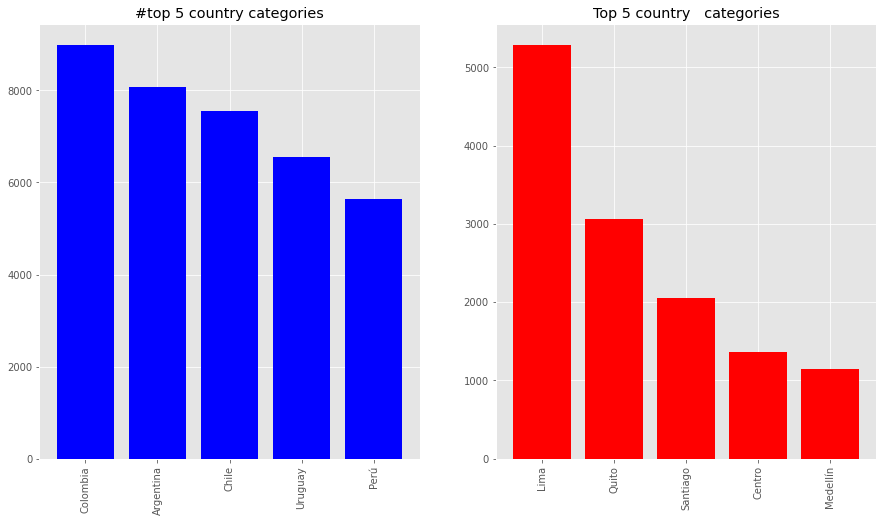

In [10]:
bar_plot(meli_ndp,['country','city'])

Graphs shown before looks interesting because, indicate that:
-  **Brasil** have a very small(**234**) amount of posts, which is less than **13%** of Bolivia number of posts.
- **Lima** covers almost! **93%** of the posts that comes from Perú.
- **Venezuela** is still a market with a continuous movement.

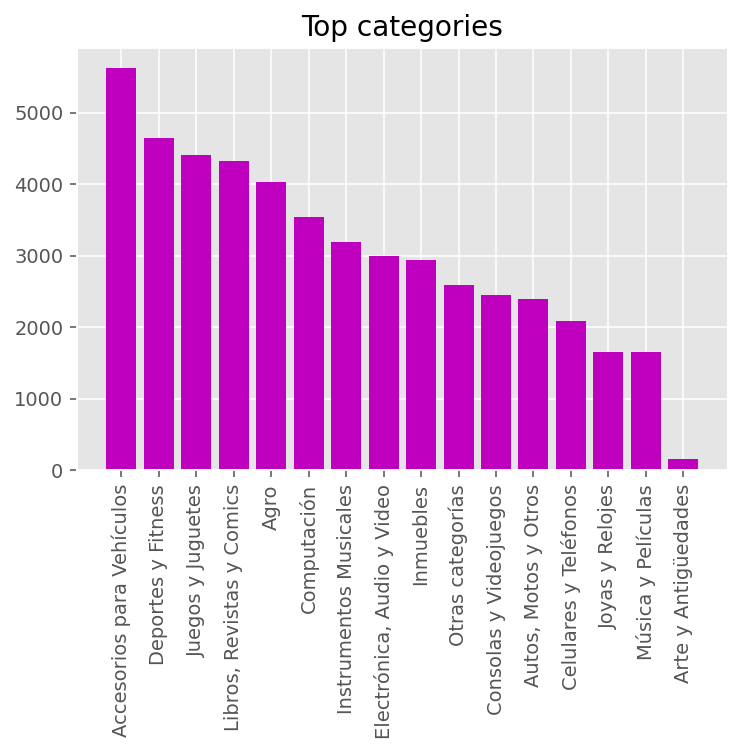

In [13]:
categories=meli_ndp['category_name'].value_counts()
plt.figure(dpi=140)
plt.bar([i for i in range(len(categories))],categories,color='m')
plt.xticks([i for i in range(len(categories))],categories.index.to_list(), rotation='90');
plt.title('Top categories')
plt.rcParams.update({'font.size':6})

<AxesSubplot:ylabel='country'>

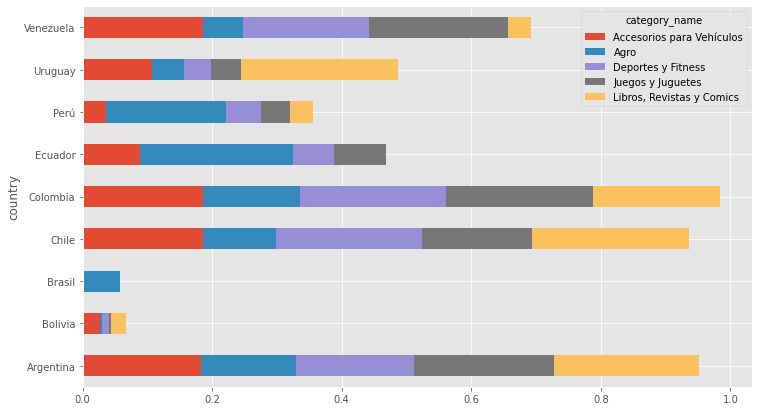

In [14]:
data_categories = meli_ndp[meli_ndp['category_name'].isin(categories[:5].index.to_list())]
plt.rcParams.update({'font.size':10})
df_categories = pd.crosstab(data_categories['country'],data_categories['category_name'],dropna=False,normalize='columns').T
df_categories.T.plot(kind='barh',stacked=True, figsize=(12,7))

## Some questions

Some questions that could be interesting and we want to address throughout this stage are:

#### BI
- ¿What's the mean of the discount for different categories?.
- ¿What users have more posts?
- ¿What products shows extremely low or high prices?
- ¿who are those less regular sellers in mercadolibre?.

#### Machine learning
- ¿ Can we find some clusters or groups that split out our sellers in segments with a clearly different sellers behavior?

### Discount for different categories 

Lets see the mean of the *discount* and *percentage discount* variables for different categories.

In [15]:
meli_discount = data_categories.copy(deep=True)

In [16]:
# create the discount field
meli_discount['discount']=meli_discount['original_price']-meli_discount['price']

In [17]:
# mean percentage discount
#discount_categories = data_categories.groupby(by=['country','category_name'])[['discount_percentage']].mean()

# mean value discount
discount_categories = meli_discount.groupby(by=['country','category_name'])[['discount']].mean()

In [18]:
# for discount value 
pivot_categories = discount_categories.pivot_table(index = 'country', columns='category_name', values='discount')

# for discount percentage
#pivot_categories = discount_categories.pivot_table(index = 'country', columns='category_name', values='discount_percentage')

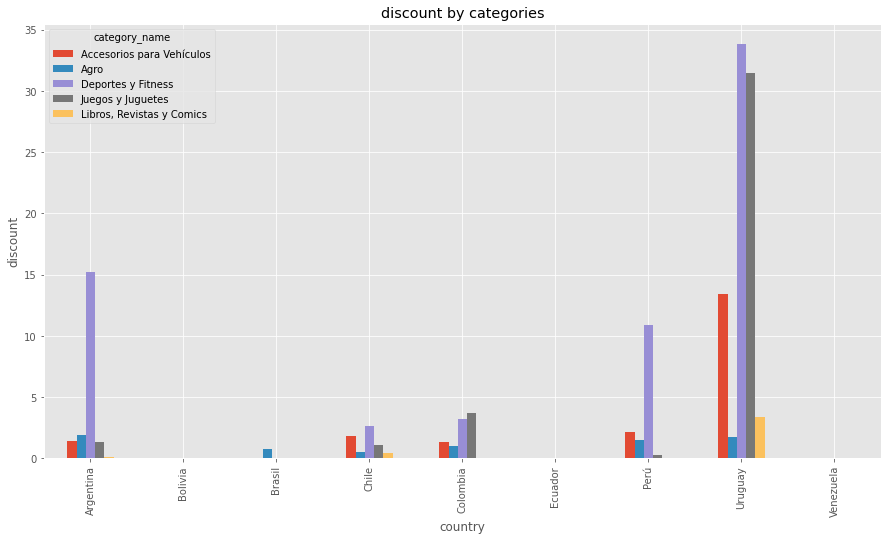

In [19]:
pivot_categories.plot(figsize=(15,8),kind='bar');
plt.title('discount by categories')
plt.ylabel('discount');

The graph show that Uruguay offers really good options in the categories *Deportes, Fitness* and *Juegos y juguetes*, but as usual, the mean is weak to the presence of outliers, as shown below.

<AxesSubplot:xlabel='price'>

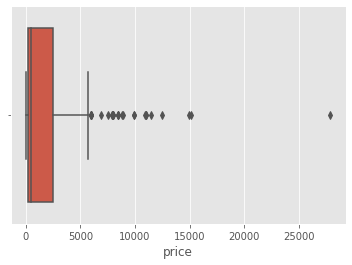

In [20]:
uruguay=meli_discount[(meli_discount['country']=='Uruguay')]

sns.boxplot(x='price', data=uruguay[uruguay['category_name']=='Deportes y Fitness'])

### Cases with extreme price values

Prices change a lot and depend of many variables, but lets search for cases that can me anomalous, and probably deserve a deeper attention.

In [21]:
#distribution of values for price column
meli_ndp[['price']].describe()

,price
count,4.872900e+04
mean,3.276773e+03
std,5.144030e+04
min,6.560000e-07
25%,1.142412e+01
50%,3.701507e+01
75%,2.759490e+02
max,8.279298e+06


As was expected the standard deviation(std) its so high, meaning that we have products so cheap and others so expensive, but its interesting that the 25% of posts have prices below 10 dollars, with some of them so close to 0! usd, probably products coming from Venezuela. In addition 25% of posts are products very expensive with prices above 1000.000 dollars!.

Lets take records with prices less than 10 dollars.

<AxesSubplot:xlabel='price', ylabel='country'>

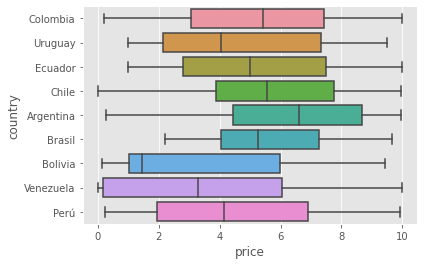

In [22]:
sns.boxplot(x='price',y='country',data=meli_ndp[meli_ndp['price']<10])

Venezuela is clearly the boxplot with a strong left tendency. Lets check what kind of products are the usual with those prices.

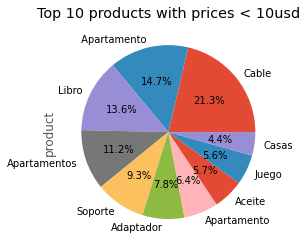

In [23]:
#Just top 10 products with prices<10.
meli_ndp[meli_ndp['price']<10]['product'].value_counts()[:10].plot(kind='pie',autopct="%.1f%%")
plt.title('Top 10 products with prices < 10usd');

Around 26%  of the cheapest products are Apartments, probably are sellers that "*erroneously*" type the values of the product.

What about super high prices?. next we show top 10 categories with that type.

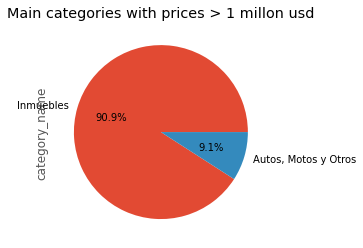

In [24]:
meli_ndp[meli_ndp['price']>1000000]['category_name'].value_counts()[:10].plot(kind='pie',autopct="%.1f%%")
plt.title('Main categories with prices > 1 millon usd');

### ¿Who are the sellers with more posts?

Sounds natural that depending of the circumstances a seller possibly can post multiple times.

In [25]:
meli_multipost = meli_data_tagged.copy(deep=True)
# extract the distribution of posts by user
values = meli_multipost['user_id'].value_counts()
user_indx = values.index.to_list()

In [26]:
# add and initialize freq_posts
meli_multipost['freq_posts'] = np.ones(meli_multipost.shape[0])
meli_multipost.reset_index(drop=True,inplace=True)

In [27]:
# fill the column of freq posts for users with multiple posts.
for user,value in zip(user_indx,values):
    user_indices = meli_multipost[meli_multipost['user_id']==user].index.to_list()
    for i in user_indices:
        meli_multipost.loc[i,'freq_posts'] = value

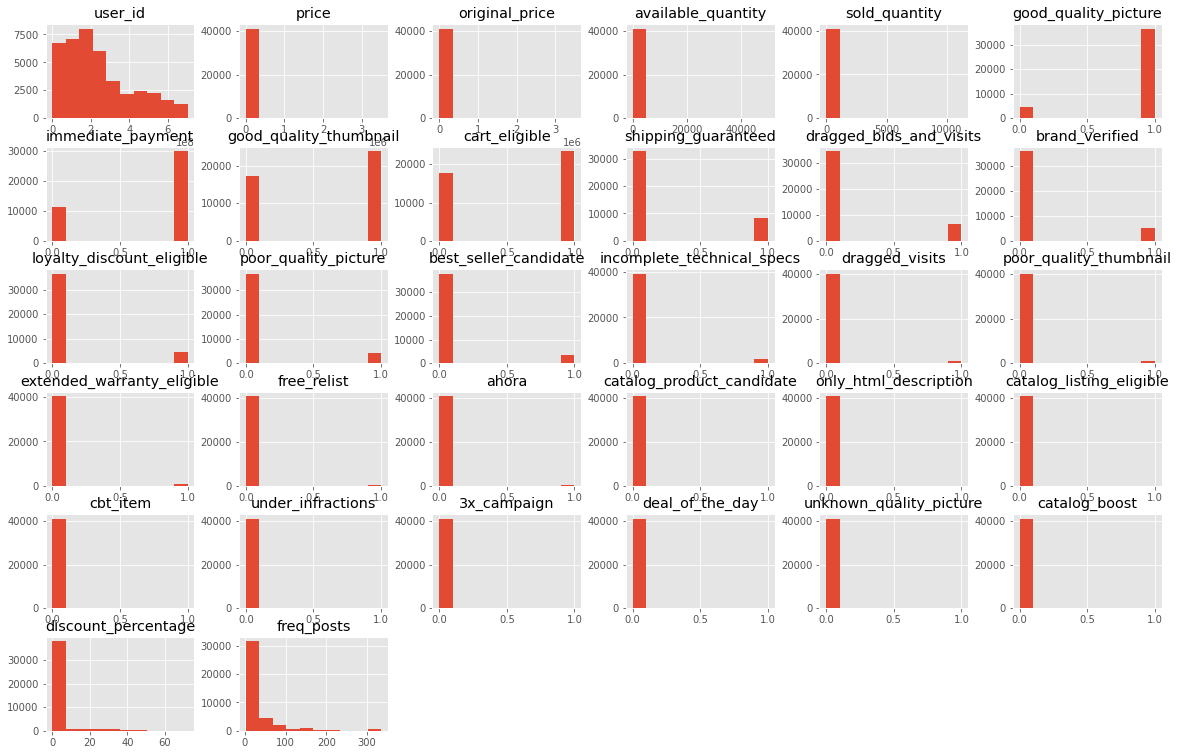

In [28]:
meli_multipost[meli_multipost['freq_posts']>1].hist(figsize=(20,13));

in the graph for *freq_posts* we can see some segmentation of the values, where a group of sellers publish up of 300! post. Looks interesting to see that those sellers are located mainly in *Uruguay* and sells books and things like that. 

Text(0.5, 1.0, '#posts by category')

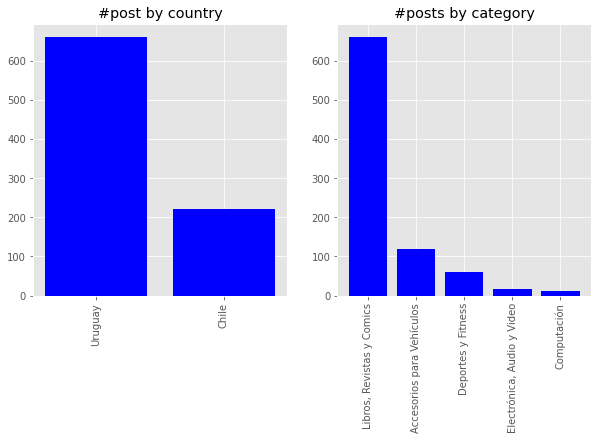

In [30]:
to_plot = meli_multipost[meli_multipost['freq_posts']>200]
countries =to_plot['country'].value_counts()
categories = to_plot['category_name'].value_counts()
indx = [i for i in range(len(countries))]
indx_categories = [i for i in range(len(categories))]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].bar(indx[:5], countries.values[:5],color='blue')
ax[0].set_xticks(indx[:5])
ax[0].set_xticklabels(countries.index.to_list()[:5], rotation='vertical');
ax[0].set_title('#post by country')

ax[1].bar(indx_categories[:5], categories.values[:5],color='blue')
ax[1].set_xticks(indx_categories[:5])
ax[1].set_xticklabels(categories.index.to_list()[:5], rotation='vertical');
ax[1].set_title('#posts by category')

### Tags variable

The variable **Tags** contains information about some features of the posts and the seller that could be a source of value to create a *profile* of different types of sellers. In that way the variable was expanded, extracting for each post all the tags and then each tag was added as a new colum in the dataframe as a binary variable. 

First all, we try to find the frequency distribution of those tags.

In [31]:
# Get the stacked list of tags, used in the cleaning stage to create all tags fields, and the tags freq dictionary
stacked_tags,tags_freq = tags_extractor(meli_ndp['tags'])

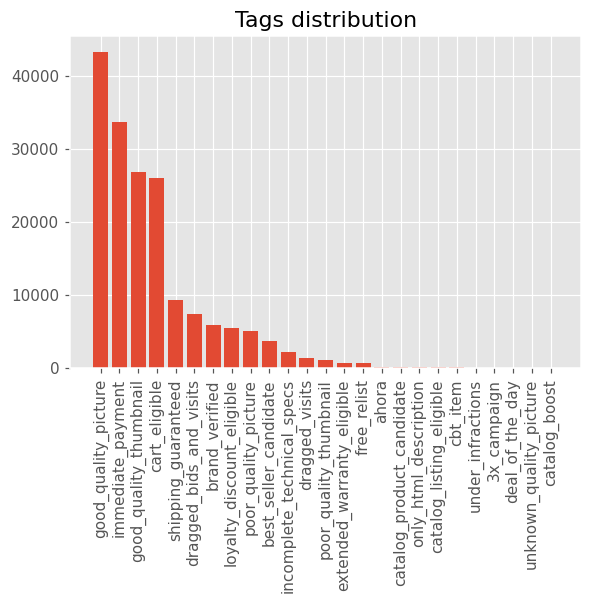

In [32]:
plt.figure(dpi=110)
range_bar_plot = range(len(tags_freq.keys()))
plt.bar([i for i in range_bar_plot],tags_freq.values() )
plt.xticks([i for i in range_bar_plot],tags_freq.keys(),rotation='vertical');
plt.title('Tags distribution');

Some tags like **good_quality_picture** or **good_quality_thumbnail** looks so common and not really meaningful to distinguish some sellers from others. However, others like **shipping guarantee** or **brand_verified**, have a lower frequency and could be features of some specific sellers, in addition some others tags like **deal_of_the_day** are very rare cases tha deserve our attention.Lets see if there is some *relationship* between those tags, understood in the binary cases like "coincidence matrix" of both tags.

In [33]:
meli_corr = meli_data_tagged.drop(columns=['price','available_quantity','sold_quantity','post_id','user_id',
                                                 'country','city','product','category_name','tags','original_price',
                                                 'discount_percentage','duplicated(Y/N)(1/0)'])

In [34]:
# separate create the three bianry variables.
condition_dummies = pd.get_dummies(meli_corr['condition'])
meli_corr = pd.concat([meli_corr,condition_dummies],axis=1)
# drop the "condition" column
meli_corr.drop(columns=['condition'],inplace=True)

Text(0.5, 1.0, 'Heatmap of dataset')

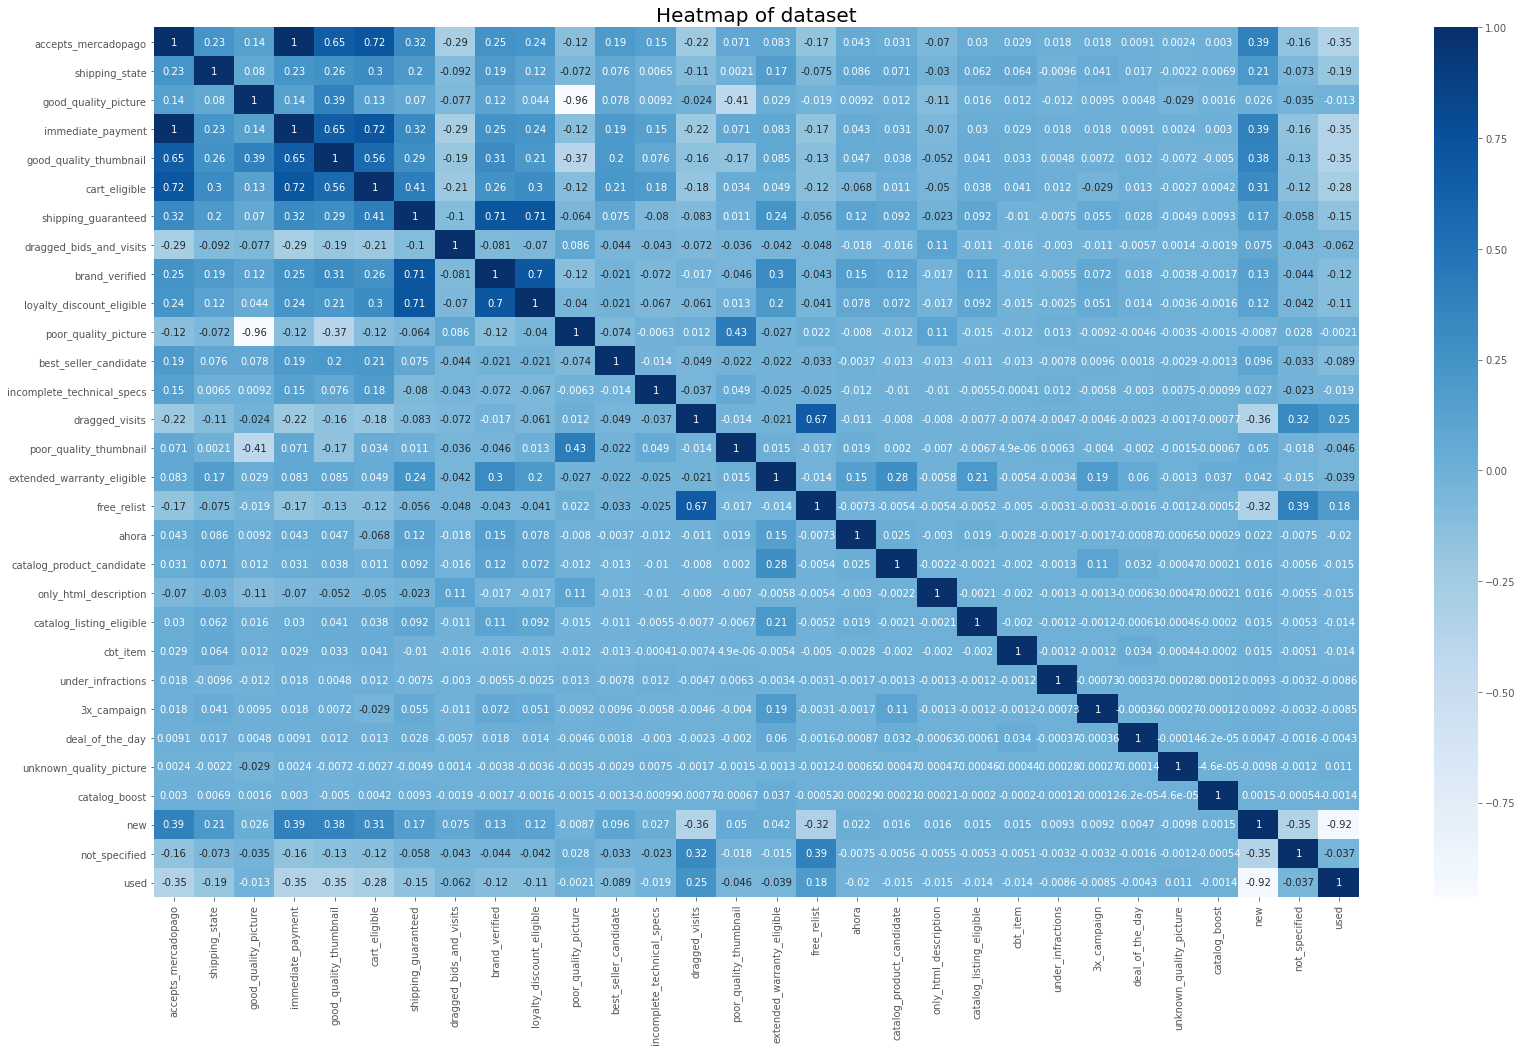

In [35]:
plt.rcParams['figure.figsize']=(27,16)
#corr = df.corr(method='pearson')
corr = meli_corr.corr(method='spearman')
hm = sns.heatmap(corr,annot=True, cmap='Blues')
hm.set_title(label='Heatmap of dataset', fontsize=20)

Some interesting facts we evidence are:
- The mercadopago pago option means that transaction requires an inmediate payment and its relative strong correlated with the option *cart_eligible*.
- "*Brand verified*" option looks in some way correlated with "*shipping guaranteed*" and in a similar way with "*loyalty discount eligible*", possible giving the customer all warranties and possible benefits for the sell.
- With the data available "*best seller candidate*" is not a clear tag that create a strong segmentation of the data.
- the others tags at this point doesn't show any relevant relationship.

Maybe some combinations of those tags let us know different sellers types, so lets run a clustering and anomaly detection analysis to check that guess.

### Unsupervised analysis using tags

To find some *clusters* that give us evidence  about some sellers behavior and with some luck to create a **seller profile**, we need to start making some attempts using the tags fields created.

In [36]:
#loading needed libraries
from sklearn.cluster import DBSCAN # for anomaly detection
from sklearn.neighbors import NearestNeighbors 
from sklearn.cluster import KMeans #traditional kmeans
from sklearn.model_selection import GridSearchCV

Before run any algorithm, the variables **accepts mercadopago** and **shippng_free** are boolean, so to use those in a clustering scenario using algorithms like kmeans, is needed to turn each one into numerical.

In [37]:
meli_data_clust = meli_multipost.copy(deep=True)

meli_data_clust['accepts_mercadopago'] = np.where(meli_data_clust['accepts_mercadopago']==True,1,0)
meli_data_clust['shipping_state'] = np.where(meli_data_clust['shipping_state'],True,0)

### Case 1: KMeans using all tags fields available.

As usual, Kmeans need the *n_cluster* parameter, so first take off numerical(price,original_price,discount_percentage)  and  categorical variables to just focuse on "tags" feautures, and try **elbow method** to test and get a sense about a convenient value for the number of clusters.

In [38]:
#taking off all categorical variables
meli_kmeans = meli_data_clust.drop(columns=['price','available_quantity','sold_quantity','post_id','user_id',
                                                 'country','city','product','category_name','tags','original_price',
                                                 'discount_percentage','condition','duplicated(Y/N)(1/0)', 'freq_posts'])
# checke that the dtypes be numerical to run kmeans
meli_kmeans = meli_kmeans.astype('float64')

In [39]:
plt.rcParams.update({'figure.figsize':[10,5]})

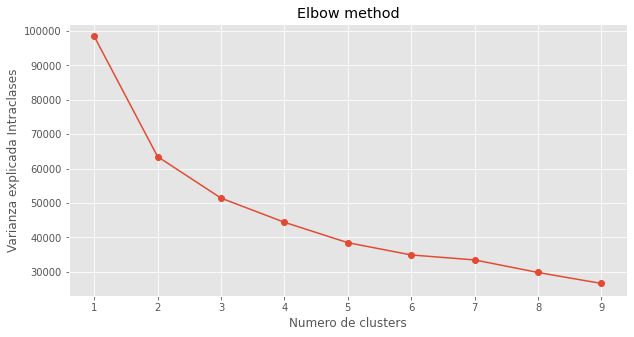

In [40]:
# using the created kmean_elbow function.
plt.plot(figsize=(10,8))
varianza1 = kmeans_elbow(meli_kmeans,10)

The curve looks so smooth and there is no a clear candidate point to choose as our *n_clust*  , so that can be a warning message , indicating that the data available could be not good enough to generate clusters!.

### Case 2: Kmeans with relevant correlated tags.

Based on the correlogram shown, lets take just the variables that exhibit some relevant correlation.

In [41]:
meli_kmeans = meli_data_clust.drop(columns=['price','available_quantity','sold_quantity','post_id','user_id',
                                            'country','city','product','category_name','tags','original_price',
                                            'discount_percentage','condition',
                                           'poor_quality_thumbnail', 'extended_warranty_eligible',
                                           'ahora', 'catalog_product_candidate', 'only_html_description',
                                           'catalog_listing_eligible', 'cbt_item', 'under_infractions',
                                           '3x_campaign', 'deal_of_the_day', 'unknown_quality_picture',
                                            'catalog_boost','good_quality_picture','good_quality_thumbnail',
                                           'dragged_bids_and_visits','poor_quality_picture','best_seller_candidate',
                                           'incomplete_technical_specs','shipping_state','duplicated(Y/N)(1/0)', 'freq_posts'])

print('Shape of the dataset',meli_kmeans.shape)

Shape of the dataset (48751, 8)


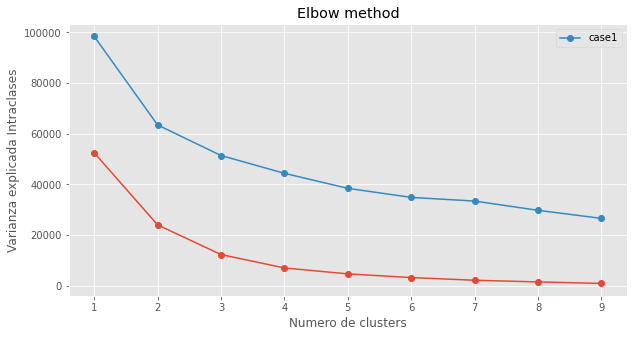

In [42]:
varianza2 = kmeans_elbow(meli_kmeans,10)
plt.plot([i for i in range(1,10)],varianza1,'-o',label='case1')
plt.legend();

The second attempt still looks bad and its not a well graph to decide what number of clusters to use, maybe as was mentioned before, those graphs indicate that the **tags data** is not really clusterizable.

### case 3: adding "condition" and more variables.

The variable "condition" has three levels: new, used, not_specified.Well We'll use each level as a new column in that way each level take just two possible values as the others tags variables.

In [43]:
meli_kmeans = meli_data_clust.drop(columns=['post_id','user_id',
                                            'country','city','product','category_name','tags','original_price',
                                           'poor_quality_thumbnail', 'extended_warranty_eligible',
                                           'ahora', 'catalog_product_candidate', 'only_html_description',
                                           'catalog_listing_eligible', 'cbt_item', 'under_infractions',
                                           '3x_campaign', 'deal_of_the_day', 'unknown_quality_picture',
                                            'catalog_boost','good_quality_picture','good_quality_thumbnail',
                                           'dragged_bids_and_visits','poor_quality_picture',
                                           'incomplete_technical_specs','shipping_state'])

print('Shape of the dataset',meli_kmeans.shape)

Shape of the dataset (48751, 16)


Turn the three levels into new binary variables.

In [44]:
# separate create the three bianry variables.
condition_dummies = pd.get_dummies(meli_kmeans['condition'])
meli_kmeans = pd.concat([meli_kmeans,condition_dummies],axis=1)
# drop the "condition" column
meli_kmeans.drop(columns=['condition'],inplace=True)
print('Shape adding new columns: ', meli_kmeans.shape)
meli_kmeans = meli_kmeans.astype('float64')

Shape adding new columns:  (48751, 18)


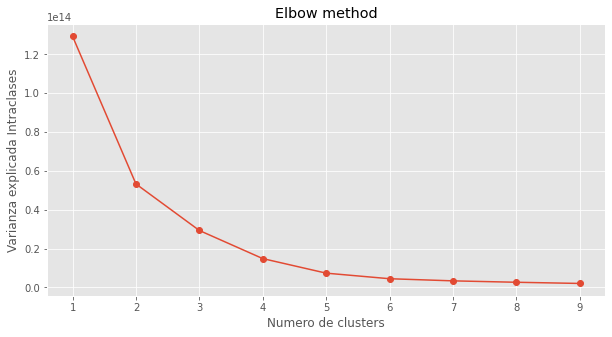

In [45]:
varianza3 = kmeans_elbow(meli_kmeans,10)

Our third attempt adding even with numerical variables like: price, discount_percentage, ..etc, show that think in a clustering analysis looks not well, and even a anomaly detection.

### Sold_quantity, available_quantity.¿numerical or categorical?.

The MELI API documentation related with those variables is located in: https://developers.mercadolibre.com.ar/es_ar/items-y-busquedas. In fact *available_quantity* is categorical, but *sold_quantity* have an **hybrid nature**, just for summary:

- **numerical**: if sold_quantity less than 5 the variable gives the real sold_quantity
- **categorical**: if sold_quantity is greater than 5 the values are *references* of some range of posible values.

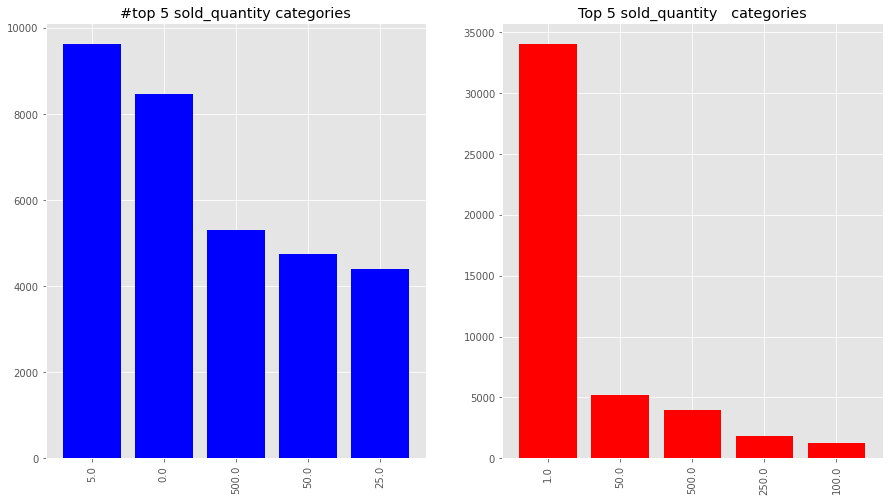

In [46]:
bar_plot(meli_kmeans,['sold_quantity','available_quantity'])

Our data has around 28% (13611) of cases where the seller have selled less than 5 products.

In [47]:
pd.DataFrame(meli_kmeans[meli_kmeans['sold_quantity']<5]['sold_quantity'].value_counts()).sum()

sold_quantity    13611
dtype: int64

### ¿ if low sold_quantity so high available_quantity or vicecersa?.

Almost 70% of the posts are about sellers in the 1 available category(0 to 50 products), where around 50% of those have sellings below 5 products. 

In [48]:
pd.DataFrame(meli_kmeans[meli_kmeans['sold_quantity']<5]['available_quantity'].value_counts()).head()

,available_quantity
1.0,12214
50.0,645
500.0,378
250.0,130
150.0,87


## Some conclusions:

- The data gave us some answers to natural business questions, but when we tried to go beyond and explore other relationships  througout segmentation and anomaly detection algorithms the data looks not enough appropiate.
- Tags have some interesting information about features and lets us detect small groups of sellers. Some of them who offer good advantages to customers: "brand_verified","shipping_guaranteed", "loyalty_discount_elegible" , and others with a high frequency of posts that could be a root for a deeper analysis.
- this is a point to start again and check other data sourcers and think about other data sources that could give us more information about sellers and its posts to get a richer data set.